# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


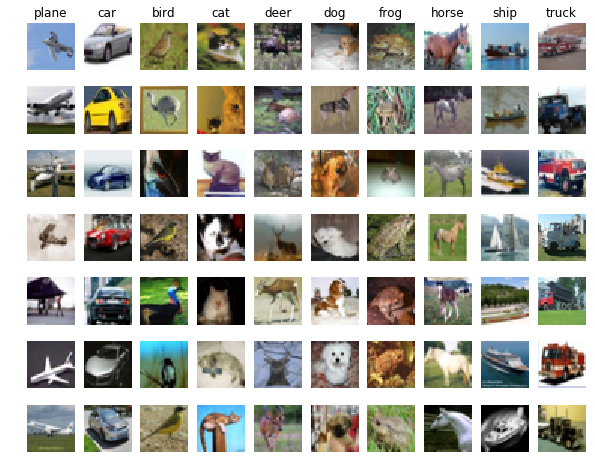

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


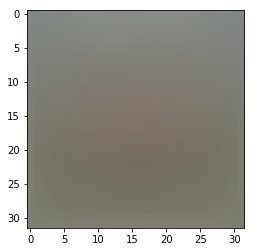

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print 'loss: %f' % (loss, )

loss: 9.102131


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -16.915276 analytic: -16.915276, minus: 0.000000, relative error: 3.458037e-12
numerical: 6.321941 analytic: 6.321941, minus: 0.000000, relative error: 3.961584e-11
numerical: 25.114286 analytic: 25.114286, minus: 0.000000, relative error: 1.827242e-11
numerical: 9.681356 analytic: 9.681356, minus: 0.000000, relative error: 1.787814e-11
numerical: -27.128142 analytic: -27.128142, minus: 0.000000, relative error: 1.407825e-14
numerical: -0.394286 analytic: -0.394286, minus: 0.000000, relative error: 5.815563e-10
numerical: 10.206944 analytic: 10.206944, minus: 0.000000, relative error: 2.401941e-11
numerical: -8.115120 analytic: -8.115120, minus: 0.000000, relative error: 2.644905e-11
numerical: -14.503256 analytic: -14.503256, minus: 0.000000, relative error: 3.673784e-12
numerical: 6.767341 analytic: 6.767341, minus: 0.000000, relative error: 2.161701e-11
numerical: -44.132933 analytic: -44.132933, minus: 0.000000, relative error: 1.505275e-12
numerical: 3.742404 analytic: 

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 9.102131e+00 computed in 0.163394s
Vectorized loss: 9.102131e+00 computed in 0.026769s
difference: 0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.168837s
Vectorized loss and gradient: computed in 0.003583s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 17.569295
iteration 100 / 1500: loss 8.013535
iteration 200 / 1500: loss 6.236368
iteration 300 / 1500: loss 5.735277
iteration 400 / 1500: loss 5.307267
iteration 500 / 1500: loss 4.692619
iteration 600 / 1500: loss 5.408737
iteration 700 / 1500: loss 4.533055
iteration 800 / 1500: loss 5.185099
iteration 900 / 1500: loss 5.210862
iteration 1000 / 1500: loss 4.723736
iteration 1100 / 1500: loss 5.074868
iteration 1200 / 1500: loss 4.811808
iteration 1300 / 1500: loss 5.295881
iteration 1400 / 1500: loss 4.902142
That took 8.681161s


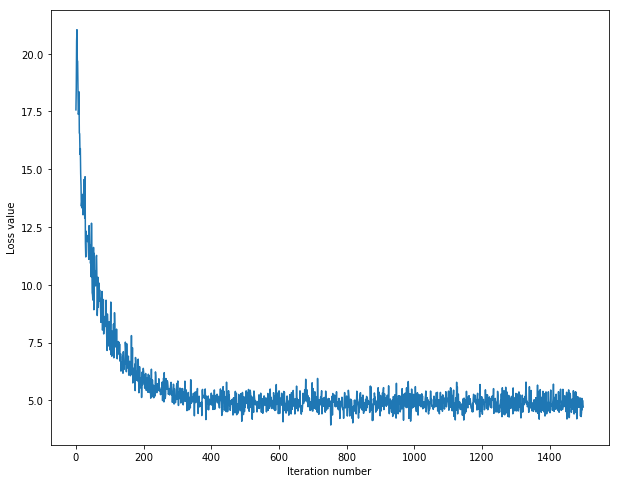

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.370918
validation accuracy: 0.381000


lr: 1e-10 reg: 0
iteration 0 / 1500: loss 24.142556
iteration 100 / 1500: loss 30.939687
iteration 200 / 1500: loss 28.438052
iteration 300 / 1500: loss 27.355084
iteration 400 / 1500: loss 27.319291
iteration 500 / 1500: loss 24.812925
iteration 600 / 1500: loss 26.229366
iteration 700 / 1500: loss 23.332527
iteration 800 / 1500: loss 27.195003
iteration 900 / 1500: loss 25.877765
iteration 1000 / 1500: loss 27.007807
iteration 1100 / 1500: loss 25.318485
iteration 1200 / 1500: loss 29.324720
iteration 1300 / 1500: loss 26.604147
iteration 1400 / 1500: loss 29.770375


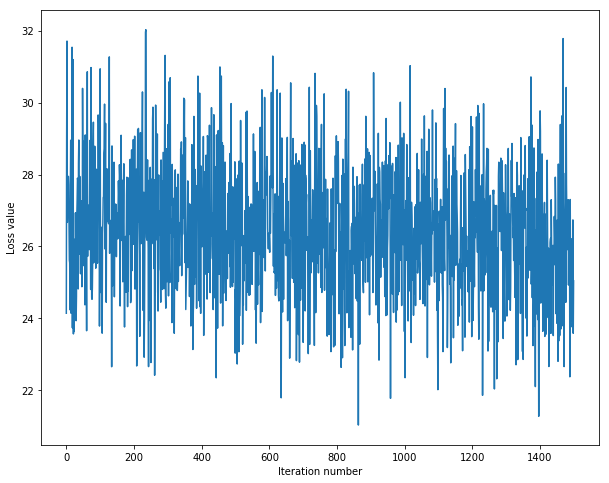

tr_acc: 0.0838979591837 val_acc: 0.076
lr: 1e-10 reg: 50000.0
iteration 0 / 1500: loss 23.454797
iteration 100 / 1500: loss 21.549885
iteration 200 / 1500: loss 19.049071
iteration 300 / 1500: loss 19.980417
iteration 400 / 1500: loss 21.668341
iteration 500 / 1500: loss 20.950544
iteration 600 / 1500: loss 21.965485
iteration 700 / 1500: loss 20.573486
iteration 800 / 1500: loss 20.082021
iteration 900 / 1500: loss 20.585139
iteration 1000 / 1500: loss 19.812138
iteration 1100 / 1500: loss 19.558766
iteration 1200 / 1500: loss 20.372976
iteration 1300 / 1500: loss 20.898368
iteration 1400 / 1500: loss 22.293906


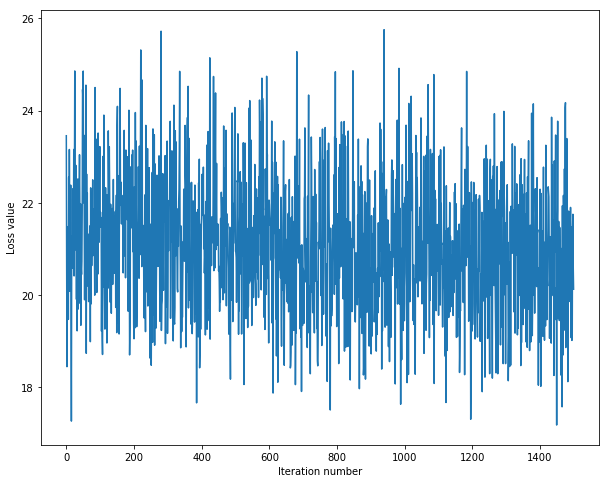

tr_acc: 0.110020408163 val_acc: 0.11
lr: 1e-10 reg: 100000.0
iteration 0 / 1500: loss 29.732855
iteration 100 / 1500: loss 26.339726
iteration 200 / 1500: loss 25.715607
iteration 300 / 1500: loss 29.550311
iteration 400 / 1500: loss 23.398934
iteration 500 / 1500: loss 26.040381
iteration 600 / 1500: loss 22.220150
iteration 700 / 1500: loss 23.664014
iteration 800 / 1500: loss 27.675695
iteration 900 / 1500: loss 24.550344
iteration 1000 / 1500: loss 22.261640
iteration 1100 / 1500: loss 23.278316
iteration 1200 / 1500: loss 25.531755
iteration 1300 / 1500: loss 24.695921
iteration 1400 / 1500: loss 24.926432


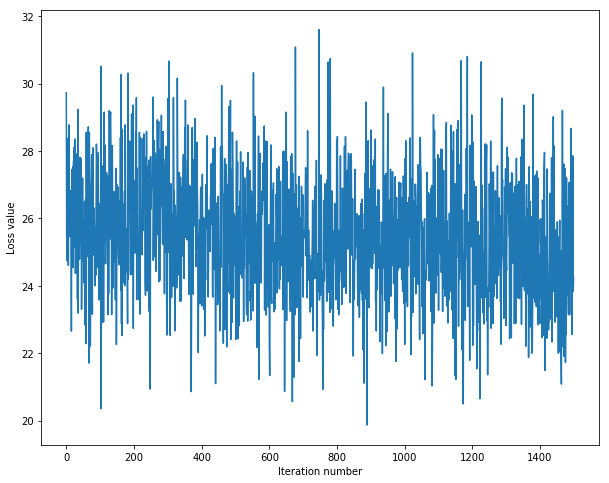

tr_acc: 0.111306122449 val_acc: 0.11
lr: 1e-10 reg: 10000000000.0
iteration 0 / 1500: loss 21.605265
iteration 100 / 1500: loss 8.999311
iteration 200 / 1500: loss 8.999014
iteration 300 / 1500: loss 8.999220
iteration 400 / 1500: loss 8.999154
iteration 500 / 1500: loss 8.999252
iteration 600 / 1500: loss 8.999118
iteration 700 / 1500: loss 8.999298
iteration 800 / 1500: loss 8.999002
iteration 900 / 1500: loss 8.999376
iteration 1000 / 1500: loss 8.999338
iteration 1100 / 1500: loss 8.998706
iteration 1200 / 1500: loss 8.999150
iteration 1300 / 1500: loss 8.999077
iteration 1400 / 1500: loss 8.999019


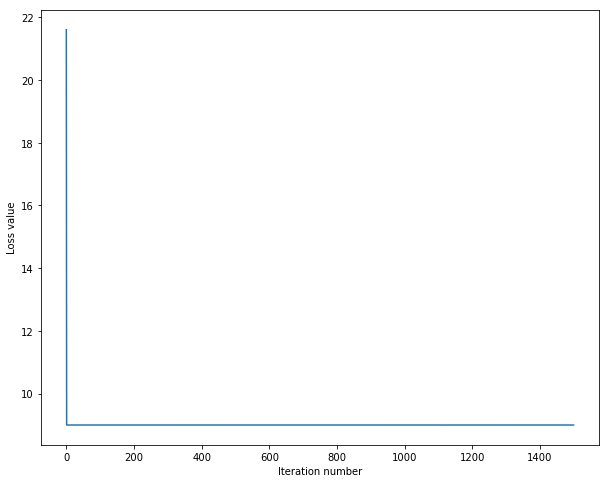

tr_acc: 0.211469387755 val_acc: 0.21
lr: 1e-08 reg: 0
iteration 0 / 1500: loss 20.987974
iteration 100 / 1500: loss 15.839994
iteration 200 / 1500: loss 15.884377
iteration 300 / 1500: loss 13.695421
iteration 400 / 1500: loss 11.465319
iteration 500 / 1500: loss 12.096625
iteration 600 / 1500: loss 11.372192
iteration 700 / 1500: loss 12.031122
iteration 800 / 1500: loss 12.164410
iteration 900 / 1500: loss 11.747418
iteration 1000 / 1500: loss 11.427915
iteration 1100 / 1500: loss 10.472098
iteration 1200 / 1500: loss 10.225585
iteration 1300 / 1500: loss 10.813771
iteration 1400 / 1500: loss 9.403460


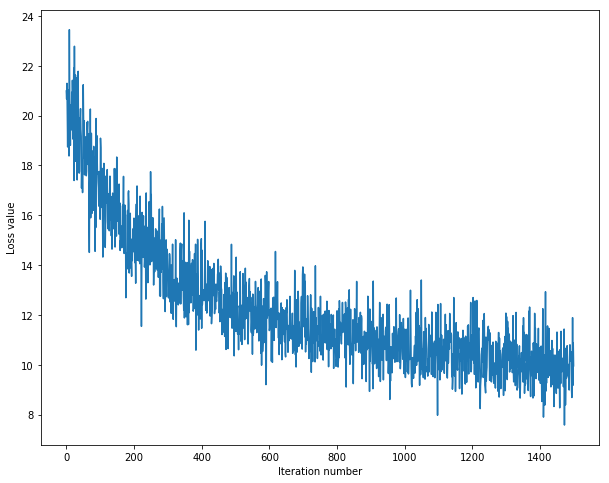

tr_acc: 0.226448979592 val_acc: 0.238
lr: 1e-08 reg: 50000.0
iteration 0 / 1500: loss 19.337047
iteration 100 / 1500: loss 15.230735
iteration 200 / 1500: loss 16.050279
iteration 300 / 1500: loss 13.296127
iteration 400 / 1500: loss 11.121520
iteration 500 / 1500: loss 10.978926
iteration 600 / 1500: loss 10.056287
iteration 700 / 1500: loss 9.416892
iteration 800 / 1500: loss 7.845549
iteration 900 / 1500: loss 8.352526
iteration 1000 / 1500: loss 7.569325
iteration 1100 / 1500: loss 8.280936
iteration 1200 / 1500: loss 7.556588
iteration 1300 / 1500: loss 7.634388
iteration 1400 / 1500: loss 7.005875


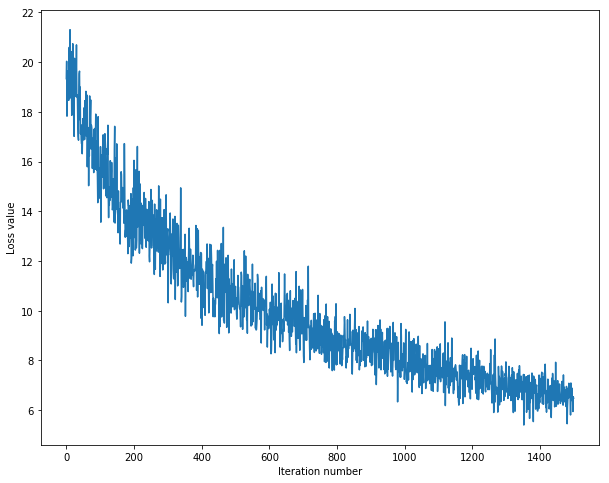

tr_acc: 0.259020408163 val_acc: 0.262
lr: 1e-08 reg: 100000.0
iteration 0 / 1500: loss 19.935985
iteration 100 / 1500: loss 17.446188
iteration 200 / 1500: loss 14.288084
iteration 300 / 1500: loss 10.683173
iteration 400 / 1500: loss 9.840453
iteration 500 / 1500: loss 8.927752
iteration 600 / 1500: loss 7.568593
iteration 700 / 1500: loss 7.537019
iteration 800 / 1500: loss 7.859104
iteration 900 / 1500: loss 7.303244
iteration 1000 / 1500: loss 6.658898
iteration 1100 / 1500: loss 6.899003
iteration 1200 / 1500: loss 5.987091
iteration 1300 / 1500: loss 6.213423
iteration 1400 / 1500: loss 5.678658


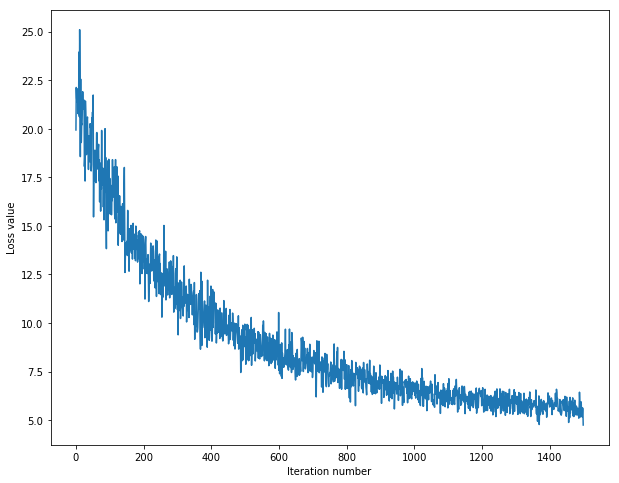

tr_acc: 0.297244897959 val_acc: 0.299
lr: 1e-08 reg: 10000000000.0
iteration 0 / 1500: loss 22.930493
iteration 100 / 1500: loss 543838149264350062652052132148217722138078386610308462519392021339449377401344995885152902305168094423135416722597162646079255905204106860848876591014753645016752158126751672039415440791519051066114048.000000


cs231n/classifiers/linear_svm.py:111: RuntimeWarning: overflow encountered in multiply
  dW += reg * W
cs231n/classifiers/linear_svm.py:106: RuntimeWarning: invalid value encountered in less
  margins[margins < 0] = 0
cs231n/classifiers/linear_svm.py:107: RuntimeWarning: invalid value encountered in greater
  margins[margins > 0] = 1


iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan


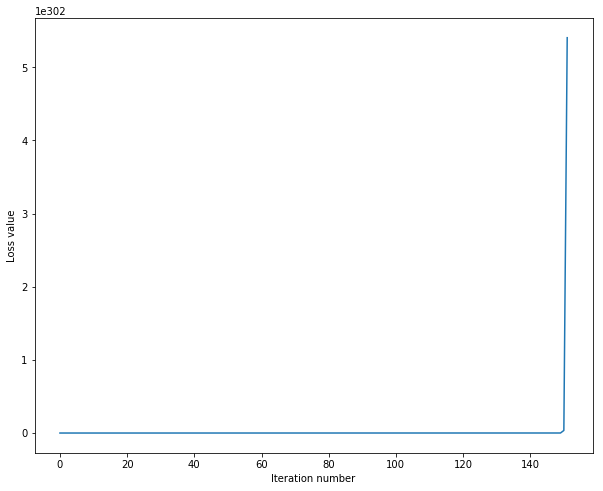

tr_acc: 0.100265306122 val_acc: 0.087
lr: 1e-07 reg: 0
iteration 0 / 1500: loss 18.588081
iteration 100 / 1500: loss 10.747812
iteration 200 / 1500: loss 10.219918
iteration 300 / 1500: loss 9.954761
iteration 400 / 1500: loss 8.530624
iteration 500 / 1500: loss 7.444042
iteration 600 / 1500: loss 7.030508
iteration 700 / 1500: loss 7.215610
iteration 800 / 1500: loss 8.035568
iteration 900 / 1500: loss 7.863341
iteration 1000 / 1500: loss 6.543339
iteration 1100 / 1500: loss 6.638269
iteration 1200 / 1500: loss 7.649769
iteration 1300 / 1500: loss 6.022872
iteration 1400 / 1500: loss 6.201900


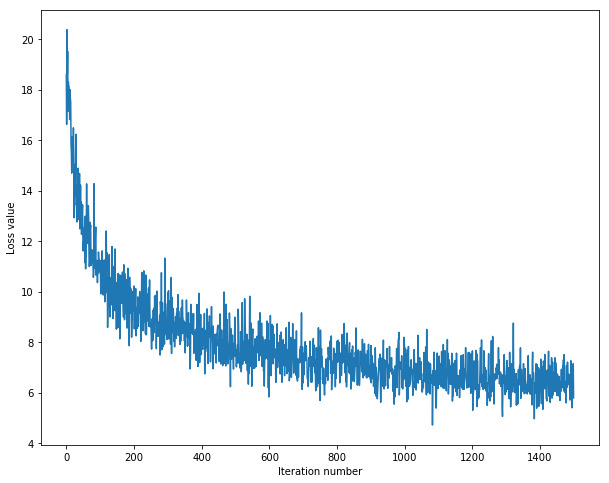

tr_acc: 0.305326530612 val_acc: 0.299
lr: 1e-07 reg: 50000.0
iteration 0 / 1500: loss 20.496123
iteration 100 / 1500: loss 7.837515
iteration 200 / 1500: loss 5.662711
iteration 300 / 1500: loss 5.218287
iteration 400 / 1500: loss 4.856434
iteration 500 / 1500: loss 4.879440
iteration 600 / 1500: loss 4.943294
iteration 700 / 1500: loss 4.478836
iteration 800 / 1500: loss 4.585908
iteration 900 / 1500: loss 4.311480
iteration 1000 / 1500: loss 4.837901
iteration 1100 / 1500: loss 4.829333
iteration 1200 / 1500: loss 5.160272
iteration 1300 / 1500: loss 4.892087
iteration 1400 / 1500: loss 4.913082


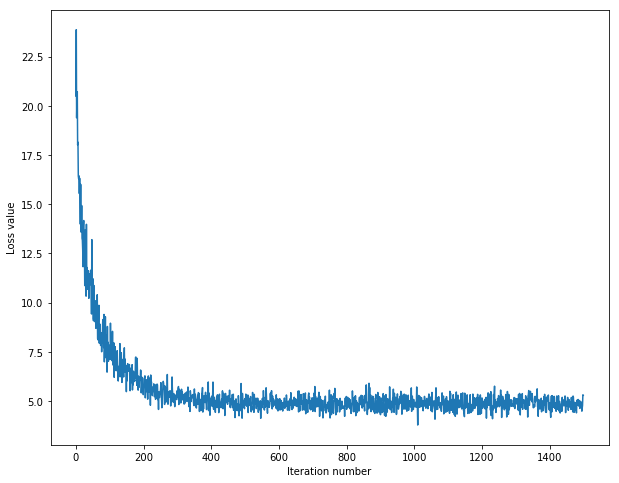

tr_acc: 0.369244897959 val_acc: 0.372
lr: 1e-07 reg: 100000.0
iteration 0 / 1500: loss 22.639743
iteration 100 / 1500: loss 6.184948
iteration 200 / 1500: loss 5.377183
iteration 300 / 1500: loss 5.190708
iteration 400 / 1500: loss 5.202002
iteration 500 / 1500: loss 4.894642
iteration 600 / 1500: loss 5.038809
iteration 700 / 1500: loss 5.099744
iteration 800 / 1500: loss 5.061864
iteration 900 / 1500: loss 6.042900
iteration 1000 / 1500: loss 5.364654
iteration 1100 / 1500: loss 4.578068
iteration 1200 / 1500: loss 5.415727
iteration 1300 / 1500: loss 4.770466
iteration 1400 / 1500: loss 5.033518


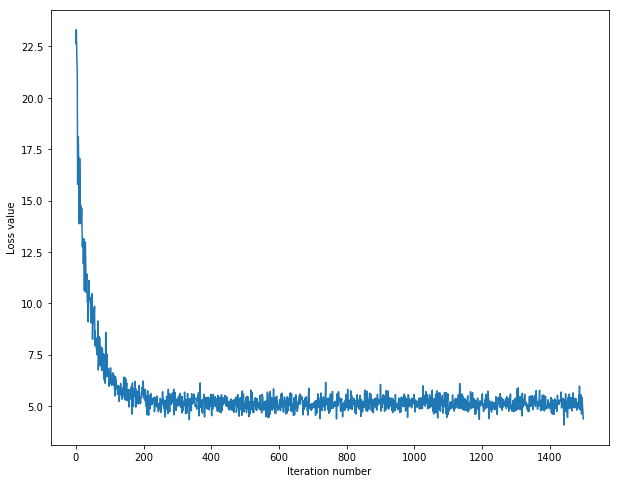

tr_acc: 0.360897959184 val_acc: 0.384
lr: 1e-07 reg: 10000000000.0
iteration 0 / 1500: loss 15.041493
iteration 100 / 1500: loss 13256364168962345017492629527729788990034166743519864678650956714550880756663726119703558993945407093719662980286162049400098464865207186450301982353227332583507102805454632016986025456890588937642227274592425802695662612735677392179411358548280118987061608553786420324251667384218283321722804530839552.000000
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan


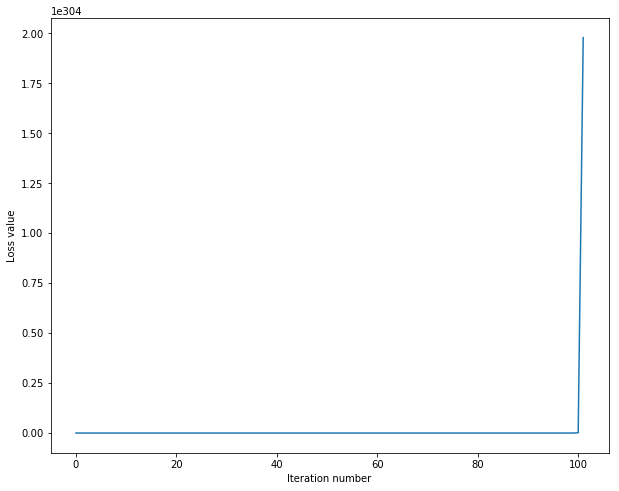

tr_acc: 0.100265306122 val_acc: 0.087
lr: 1e-05 reg: 0
iteration 0 / 1500: loss 21.134792
iteration 100 / 1500: loss 17.680246
iteration 200 / 1500: loss 20.942990
iteration 300 / 1500: loss 22.167185
iteration 400 / 1500: loss 12.809436
iteration 500 / 1500: loss 21.672750
iteration 600 / 1500: loss 20.879807
iteration 700 / 1500: loss 19.593438
iteration 800 / 1500: loss 22.055748
iteration 900 / 1500: loss 19.228576
iteration 1000 / 1500: loss 16.709591
iteration 1100 / 1500: loss 17.397374
iteration 1200 / 1500: loss 15.638314
iteration 1300 / 1500: loss 19.791262
iteration 1400 / 1500: loss 16.737875


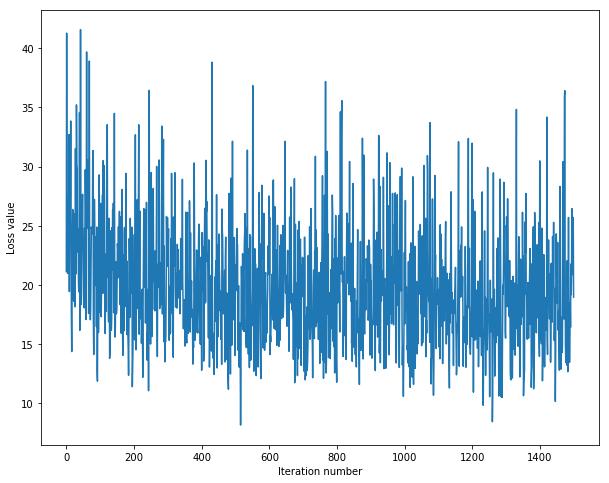

tr_acc: 0.358571428571 val_acc: 0.342
lr: 1e-05 reg: 50000.0
iteration 0 / 1500: loss 23.972662
iteration 100 / 1500: loss 39.899310
iteration 200 / 1500: loss 38.075446
iteration 300 / 1500: loss 52.577450
iteration 400 / 1500: loss 36.167866
iteration 500 / 1500: loss 33.421331
iteration 600 / 1500: loss 41.037450
iteration 700 / 1500: loss 47.550042
iteration 800 / 1500: loss 43.077925
iteration 900 / 1500: loss 30.581241
iteration 1000 / 1500: loss 60.039226
iteration 1100 / 1500: loss 51.843311
iteration 1200 / 1500: loss 43.161363
iteration 1300 / 1500: loss 35.953227
iteration 1400 / 1500: loss 59.540914


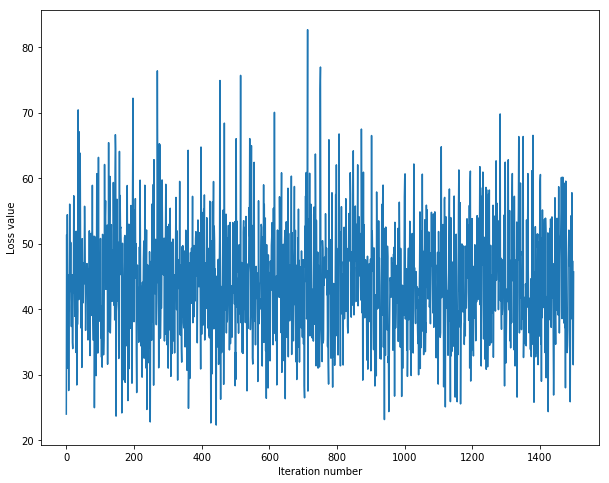

tr_acc: 0.165142857143 val_acc: 0.173
lr: 1e-05 reg: 100000.0
iteration 0 / 1500: loss 18.199998
iteration 100 / 1500: loss 80.699891
iteration 200 / 1500: loss 65.562143
iteration 300 / 1500: loss 75.189165
iteration 400 / 1500: loss 67.319029
iteration 500 / 1500: loss 101.704724
iteration 600 / 1500: loss 90.200244
iteration 700 / 1500: loss 69.310535
iteration 800 / 1500: loss 69.895857
iteration 900 / 1500: loss 82.071355
iteration 1000 / 1500: loss 66.962040
iteration 1100 / 1500: loss 68.993304
iteration 1200 / 1500: loss 62.110704
iteration 1300 / 1500: loss 71.656097
iteration 1400 / 1500: loss 75.669046


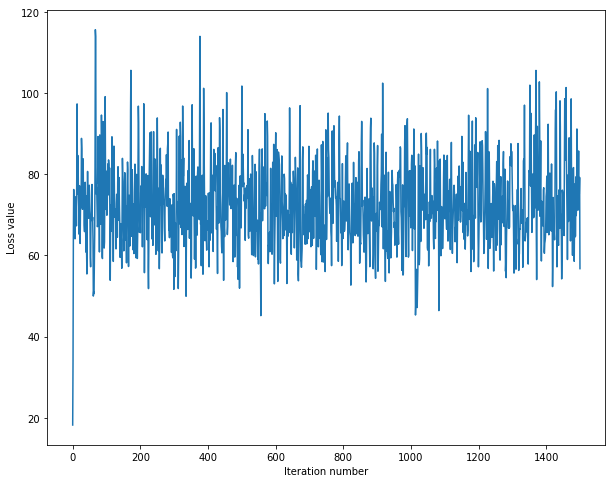

tr_acc: 0.182428571429 val_acc: 0.188
lr: 1e-05 reg: 10000000000.0
iteration 0 / 1500: loss 23.010163
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan


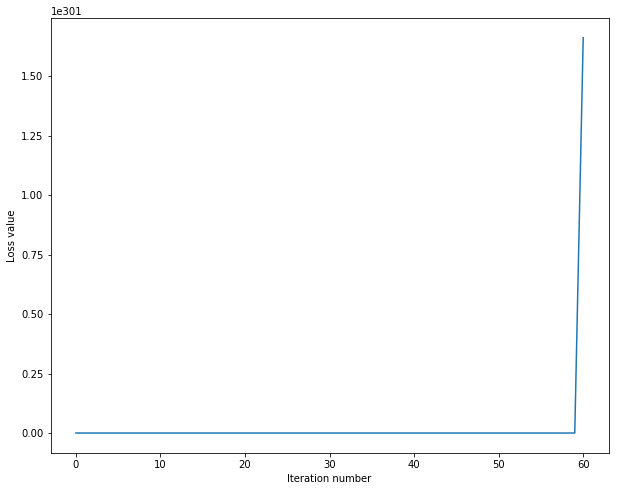

tr_acc: 0.100265306122 val_acc: 0.087
lr 1.000000e-10 reg 0.000000e+00 train accuracy: 0.083898 val accuracy: 0.076000
lr 1.000000e-10 reg 5.000000e+04 train accuracy: 0.110020 val accuracy: 0.110000
lr 1.000000e-10 reg 1.000000e+05 train accuracy: 0.111306 val accuracy: 0.110000
lr 1.000000e-10 reg 1.000000e+10 train accuracy: 0.211469 val accuracy: 0.210000
lr 1.000000e-08 reg 0.000000e+00 train accuracy: 0.226449 val accuracy: 0.238000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.259020 val accuracy: 0.262000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.297245 val accuracy: 0.299000
lr 1.000000e-08 reg 1.000000e+10 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-07 reg 0.000000e+00 train accuracy: 0.305327 val accuracy: 0.299000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.369245 val accuracy: 0.372000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.360898 val accuracy: 0.384000
lr 1.000000e-07 reg 1.000000e+10 train accuracy: 0.100265 val accuracy:

In [16]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-10, 1e-8, 1e-7, 1e-5]
regularization_strengths = [0, 5e4, 1e5, 1e10]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
from cs231n.classifiers import LinearSVM
for lr in learning_rates:
    for reg in regularization_strengths:
        print "lr:", lr, "reg:", reg
        svm = LinearSVM()
        # first time set num_iters=200
        loss_hist = svm.train(X_train, y_train, lr, reg, num_iters=1500, verbose=True) 
        y_train_pred = svm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
        plt.plot(loss_hist)
        plt.xlabel('Iteration number')
        plt.ylabel('Loss value')
        plt.show()
        print 'tr_acc:', train_acc, 'val_acc:', val_acc
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

(1e-08, 100000.0)
(1e-10, 0)
(1e-07, 100000.0)
(1e-05, 0)
(1e-07, 50000.0)
(1e-08, 0)
(1e-10, 10000000000.0)
(1e-05, 100000.0)
(1e-05, 50000.0)
(1e-10, 50000.0)
(1e-05, 10000000000.0)
(1e-07, 0)
(1e-07, 10000000000.0)
(1e-10, 100000.0)
(1e-08, 50000.0)
(1e-08, 10000000000.0)


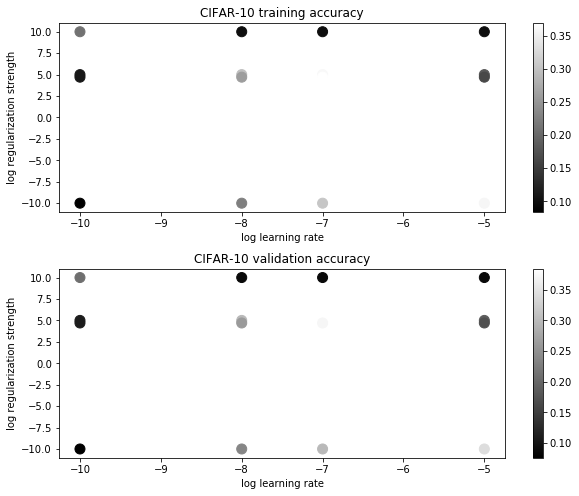

In [18]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]+1e-10) for x in results]
for x in results:
    print x

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

plt.subplots_adjust(hspace = 0.3)

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [19]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.348000


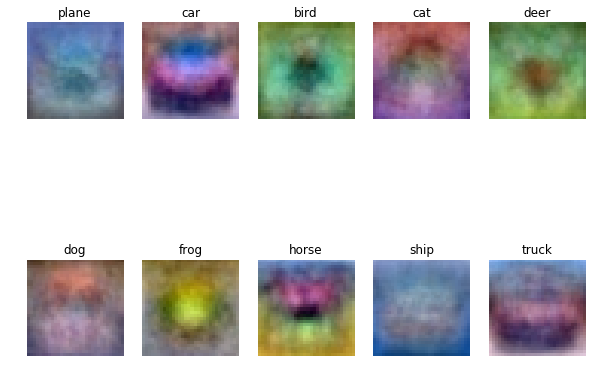

In [20]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*